In [2]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from sklearn import svm
from pycontractions import Contractions
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import emoji
import re
import os

#had to set to java 8 to satisfy problems with language-check. Language-check is pycontractions dependency
# os.setenv("JAVA_8_HOME")
os.environ['JAVA_HOME'] = os.getenv("JAVA_8_HOME")
# print(os.environ)
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
nltk.download('wordnet')

cont = Contractions('GoogleNews-vectors-negative300.bin')
cont.load_models()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayankrikh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayankrikh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def clean_file(filename):
    #check the null etc kinds of data on one item. Likely that all items will have a similar structure. Basically try and figure
    #out how empty and null items are listed
    filepath = './data/' + filename
    main = pd.read_csv(filepath)
#     print(main.head())
    #head shows there are plenty of NaN values

    #create a copt for modifications. This is just in case we want to reset values anywhere and don't end up messing with the data.
    main_copy = main.copy()

    #check for na values
#     print(main_copy.isna().sum())

    #some elements from above have all columns that are NaN. So those columns are useless and we should remove them
    #print shape before and after to see if na elements are removed afterwards
#     print(main_copy.shape)
    #columns
    main_copy.dropna(axis=1, how='all', inplace=True)
    #rows
    main_copy.dropna(axis=0, how='all', inplace=True)
#     print(main_copy.shape)

    #check all columns
#     print(main_copy.columns)
    #remove all unnecessary columns
    main_copy.drop(columns=['hashtags', 'id' ,'urls', 'language', 'mentions', 'place', 'user_id', 'created_at', 'time', 'conversation_id','reply_to', 'thumbnail', 'video', 'quote_url', 'retweet', 'link', 'cashtags', 'photos', 'timezone', 'name'], inplace=True)

    #remove duplicates
    main_copy.drop_duplicates(subset='tweet')

    #too much data...limit tweets
    temp = main_copy.sample(n = 1000)
    return temp

In [3]:
all_files = os.listdir('./data')
data_frames = []

for filename in all_files:
    #below line to not consider the ipynb checkpoints file
    if not filename.startswith('.'):
        data_frames.append(clean_file(filename))
    
#combine. Ignore_index used to make sure duplicte indexest aren't present as otherwise this would cause error in showing confusion matrix
df = pd.concat(data_frames, ignore_index = True)
df.shape

(12000, 6)

Detect the sentiment using VADER

In [4]:
analyzer = SentimentIntensityAnalyzer()
df['score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
conditions = [df.score >= .05, df.score <= -.05]
sentiment = ['positive', 'negative']
df['sentiment'] = np.select(conditions, sentiment, 'neutral')

In the cleaned dataframes, remove http links and mentions. I have left in emoticons to use them in the analysis as well.

In [5]:
#made from wikipedia list
emots = {
    "happy" : ":‑) :) :-] :] :-3 :3 :-> :> 8-) 8) :-} :} :o) :c) :^) =] =)",
    "laughing" : ":‑D :D 8‑D 8D x‑D xD X‑D XD =D =3 B^D"    ,
        "sad" : ":‑( :( :‑c :c :‑< :< :‑[ :[ :-|| >:[ :{ :@ :( ;(",
    "crying" : ":'‑( :'(",
    "happiness" : ":'‑) :')",
"sad" : "D‑': D:< D: D8 D; D= DX",
"surprise" : ":‑O :O :‑o :o :-0 8‑0 >:O",
"kiss" : ":-* :* :×",
"wink" : ";‑) ;) *-) *) ;‑] ;] ;^) :‑, ;D",
"playful" : ":‑P :P X‑P XP x‑p xp :‑p :p :‑Þ :Þ :‑þ :þ :‑b :b d: =p >:P",
"annoyed" : ":‑/ :/ :‑. >:\ >:/ :\ =/ =\ :L =L :S",
"indecision" : ":‑| :|",
"sick" : ":‑###.. :###..",
"disaproval" : "',:-| ',:-l"
        }

final_emoji_dict = {}

#since we want emojis as keys to make the fetch faster, we will manipulate the emots dictionary
for key, value in emots.items():
    emots_array = value.split(' ')
    for value in emots_array:
        final_emoji_dict[value] = key

In [6]:
#iterate over each tweet and clean it
def clean(tweet, stopwords):
    temp = str(tweet).lower()
    temp = re.sub(r"(http|@)\S+", "", temp)
    
    tweet_split = temp.split(' ')
    for index, word in enumerate(tweet_split):
        if word in final_emoji_dict:
            tweet_split[index] = final_emoji_dict[word]
            
            
    temp = ' '.join(tweet_split)
    
    #to make emoji into proper words so can't use a tokenizer as that will convert them to utc
    temp = emoji.demojize(temp)
    temp = temp.replace(':', ' ')
    temp = list(cont.expand_texts([temp]))[0]
    
    tokenizer = TweetTokenizer()
    result = tokenizer.tokenize(temp)
    
    #see how looool changes from lemmatizer
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in result if word not in stopwords]
    
    return ' '.join(words)

#stop words
stop_words = stopwords.words('english')
stop_words += ['covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
                'vaccine', '#vaccine']

#initially had a for loop. Changed to apply as it operates on entire column and makes it faster.
df['clean'] = df['tweet'].apply(lambda x: clean(x, stop_words))
#writing to csv just to view it since loading in jupyter can be slow
# First we remove generic stop words in the english language from the nltk corpus
# df.to_csv('cleaned.csv')

NLP techniques part

In [7]:
tf_idf = TfidfVectorizer(min_df=100)
data_tf_idf = tf_idf.fit_transform(df.clean)

x_final = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())
y = df['sentiment']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3, stratify=y, random_state=1)

In [9]:
resultsDict = {}

SVM

In [10]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear']}
gridSVC = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0, cv = 5) 
gridSVC.fit(x_train, y_train)
y_preds_SVM = gridSVC.predict(x_test)

print('classification report: ' + classification_report(y_test, y_preds_SVM))
accuracy_score_svm = accuracy_score(y_test, y_preds_SVM)
print('accuracy score: ' + str(accuracy_score_svm * 100))
resultsDict['SVM'] = gridSVC.cv_results_['mean_test_score']

classification report:               precision    recall  f1-score   support

    negative       0.57      0.42      0.49       914
     neutral       0.57      0.82      0.67      1258
    positive       0.77      0.61      0.68      1428

    accuracy                           0.63      3600
   macro avg       0.64      0.62      0.61      3600
weighted avg       0.65      0.63      0.63      3600

accuracy score: 63.416666666666664


Logistic Regression

In [11]:
n = np.arange(-2,3)
r = pow(float(10),n)

param_grid = {'C': r}
gridLR = GridSearchCV(LogisticRegression(max_iter = 500), param_grid, refit = True, verbose = 0, cv = 5) 
gridLR.fit(x_train, y_train)
y_preds_LR = gridLR.predict(x_test)
print(classification_report(y_test, y_preds_LR))

accuracy_score_lr = accuracy_score(y_test, y_preds_LR)
print('accuracy score: ' + str(accuracy_score_lr * 100))
resultsDict['LR'] = gridLR.cv_results_['mean_test_score']

              precision    recall  f1-score   support

    negative       0.56      0.44      0.49       914
     neutral       0.60      0.77      0.67      1258
    positive       0.73      0.64      0.68      1428

    accuracy                           0.64      3600
   macro avg       0.63      0.62      0.62      3600
weighted avg       0.64      0.64      0.63      3600

accuracy score: 63.638888888888886


Multinomial NB

In [12]:
n = np.arange(-2,3)
r = pow(float(10),n)

param_grid = {'alpha': r}
gridMNB = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 0, cv = 5) 
gridMNB.fit(x_train, y_train)
y_preds_MNB = gridMNB.predict(x_test)
print(classification_report(y_test, y_preds_MNB))

accuracy_score_mnb = accuracy_score(y_test, y_preds_MNB)
print('accuracy score: ' + str(accuracy_score_mnb * 100))
resultsDict['MNB'] = gridMNB.cv_results_['mean_test_score']

              precision    recall  f1-score   support

    negative       0.57      0.40      0.47       914
     neutral       0.60      0.66      0.63      1258
    positive       0.63      0.70      0.66      1428

    accuracy                           0.61      3600
   macro avg       0.60      0.59      0.59      3600
weighted avg       0.61      0.61      0.60      3600

accuracy score: 60.916666666666664


Compare overall count of tweets established using VADER. More positive than negative

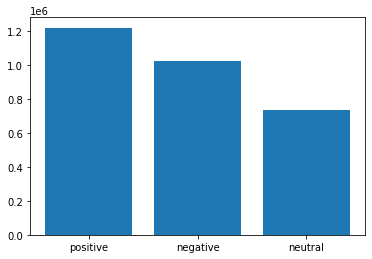

In [4]:
import matplotlib.pyplot as plt

all_files = os.listdir('./data')
data_frames = []

for filename in all_files:
    #below line to not consider the ipynb checkpoints file
    if not filename.startswith('.'):
        filepath = './data/' + filename
        main = pd.read_csv(filepath)
        data_frames.append(main)

df = pd.concat(data_frames, ignore_index = True)

analyzer = SentimentIntensityAnalyzer()
df['score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

conditions = [df.score >= .05, df.score <= -.05]

sentiment = [
    'positive',
    'negative'
]
df['sentiment'] = np.select(conditions, sentiment, 'neutral')

count = df.sentiment.value_counts()
plt.bar(df.sentiment.unique(), count)
plt.show()

Convert date to date time

In [5]:
df['positive'] = df['sentiment'].map(lambda x: x == 'positive')
df['negative'] = df['sentiment'].map(lambda x: x == 'negative')
df['neutral'] = df['sentiment'].map(lambda x: x == 'neutral')

df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
df_empty = df.drop(columns=[ 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'username', 'tweet', 'replies_count', 'retweets_count', 'likes_count', 'score', 'sentiment', 'hashtags', 'id' ,'urls', 'language', 'mentions', 'place', 'user_id', 'created_at', 'time', 'conversation_id','reply_to', 'thumbnail', 'video', 'quote_url', 'retweet', 'link', 'cashtags', 'photos', 'timezone', 'name'])
df_grouped = df_empty.groupby(df['date'].dt.month).sum()

print(df_grouped)

      positive  negative  neutral
date                             
1         8944      6645     8908
2        14352     12048    16959
3        79659     66762    70797
4       104256     76100    92189
5       103927     69631    86670
6        51410     30938    48284
7       116757     57702    89287
8        94737     54909    87146
9        96054     67849    89760
10       73925     51633    59204
11      179537     74454   112232
12      298339    169473   266059


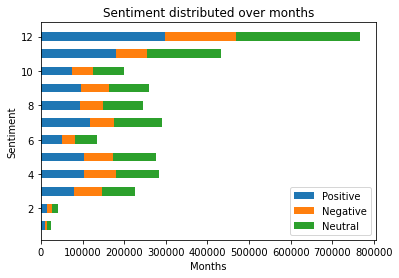

In [6]:
result = df_grouped.reset_index()

w = 0.50

x = result['date']
positive = result['positive']
negative = result['negative']
neutral = result['neutral']

combined = np.add(positive, negative)

plt.barh(x, positive, w, label = 'Positive')
plt.barh(x, negative, w, left = positive, label = 'Negative')
plt.barh(x, positive, w, left = combined, label = 'Neutral')

plt.xlabel('Months')
plt.ylabel('Sentiment')
plt.title('Sentiment distributed over months')
plt.legend()
plt.show()

In [7]:
fig = plt.figure()
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(list(resultsDict.values()))
ax.set_xticklabels(list(resultsDict.keys()))
plt.show()

NameError: name 'resultsDict' is not defined